<a href="https://colab.research.google.com/github/vifirsanova/compling/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Курс В.И. Фирсановой для факультета филологии НИУ ВШЭ (Санкт-Петербург)`

In [ ]:
!pip install accelerate -U

# Классификация с помощью BERT

В этом туториале мы научимся пользоваться библиотеками [Datasets](https://huggingface.co/docs/datasets/), [Transformers](https://huggingface.co/docs/transformers/) и [Evaluate](https://huggingface.co/docs/evaluate/) из платформы для трансферного обучения [HuggingFace](https://huggingface.co/).

**Цель:** произвести тонкую настройку (файн-тюнинг) модели BERT для бинарной классификации текстов.

**Материал:** датасет [MRPC](https://paperswithcode.com/dataset/mrpc) из бенчмарка [GLUE](https://gluebenchmark.com/).

**Задание:** использовать образец из туториала, чтобы зафайнтюнить любую другую модель на любом другом датасете на свой вкус 🤗

## Немного теории

### Модель: BERT

["BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" (Devlin et al. 2018)](https://aclanthology.org/N19-1423.pdf)

- **Файн-тюнинг**: мы используем "готовую" модель, обученную на данных открытой предметной области, общей задачи или распространенного языка и *тонко настраиваем* ее параметры для решения *узкой* задачи.

- **Кодер Transformer**: двунаправленная модель для создания эмбеддингов.

**Masked Language Modeling (MLM)**

["Cloze procedure: A new tool for measuring readability" (Taylor, 1953)](https://gwern.net/doc/psychology/writing/1953-taylor.pdf)

Психологический тест, инструмент оценки "читабельности" текста для журналистов.

Источник: гештальт-психология, способность увидеть целостный образ, даже когда часть содержимого скрыта [от читателя].

Метод Cloze:
1. удалить каждое n-ное слово
2. заменить его пропуском длины k, чтобы длина пропуска не влияла на предсказание читателя
3. попросить фокус-группу читателей угадать пропущенное слово
4. оценить "читабельность" как долю правильных предсказаний

MLM:
1. случайно замаскировать токены входных данных
2. обучить модель предсказывать замаскированное слово по его контексту (выводить ID наиболее правдоподобного токена из словаря)

*MLM обеспечивает двунаправленность при построении эмбеддингов (улучшенный Skip-Gram)*

**Next Sentence Prediction (NSP)**

Аналог Natural Language Inference (также основа для вопросно-ответных систем, согласно теории речевых актов):
- поиск связи между 2-мя предложениями
- данные - любой одноязычный корпус (извлеки 2 предложения как биграммы)
- 2 метки: isNext, notNext

*NSP позволяет искать связи не только на уровне токенов, но и на уровне предложений*

**BERT для классификации**

Процесс тонкой настройки не отличается от обучения:

1. модель "заполняет пропуски"

2. модель классифицирует пары предложений

Так мы "уточняем" предобученные эмбеддинги (тонко настраиваем параметры) для узкой предметной области.

Q: Как мы задаем предметную область?

A: Используем в качестве "дообучающих" данных специальный датасет.

Q: Но одних эмбеддингов недостаточно для решения узкой задачи. Что меняется при тонкой настройке BERT?

A: Добавляется "верхний" слой для классификации токенов.

Выходной слой BERT: векторные представления токенов "скармливаются" линейному слою для решения вашей задачи. Например, классификация последовательностей, извлечение токенов.

*Тонкая настройка модели с обобщенными знаниями о языке быстрее и вычислительно дешевле*

### Данные: GLUE

Бенчмарк [The General Language Understanding Evaluation (GLUE)](https://huggingface.co/datasets/glue)

- коллекция ресурсов (датасетов) для обучения и оценки моделей для понимания ЕЯ + лидерборд
  - The Stanford Sentiment Treebank
  - Microsoft Research Paraphrase Corpus
  - Winograd NLI

SST

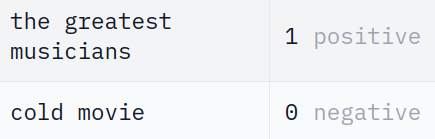

[Recursive Deep Models for Semantic CompositionalityOver a Sentiment Treebank, Socher et al., 2013](https://aclanthology.org/D13-1170.pdf)

- рецензии Rotten Tomatoes

- аннотация с помощью Stanford Parser - выделение фраз, присвоение меток {--, -, 0, +, ++}

- версии датасетов:
  - более мелкие / крупные фразы;
  - многоклассовая / бинарная классификация

MRPC

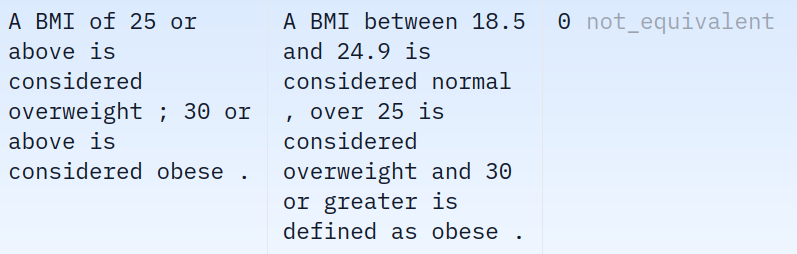

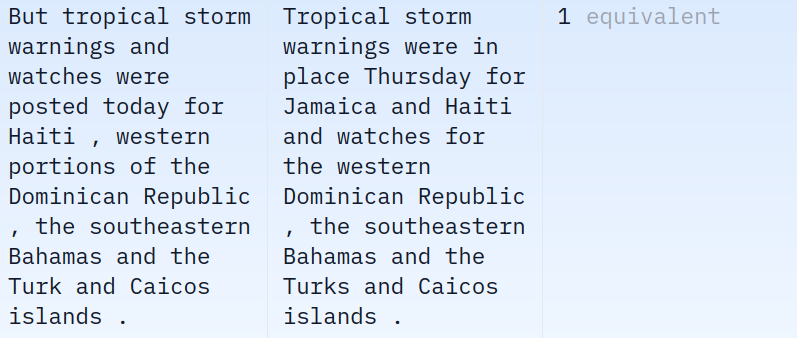

["Automatically Constructing a Corpus of Sentential Paraphrases", Dolan & Brockett](https://aclanthology.org/I05-5002.pdf)

- эвристика для выявления схожих фраз: поиск наиболее близких по вектору предложений с помощью SVM

- поиск правдоподобных парафраз в корпусе новостей

- ручная разметка, бинарная классификация

WNLI

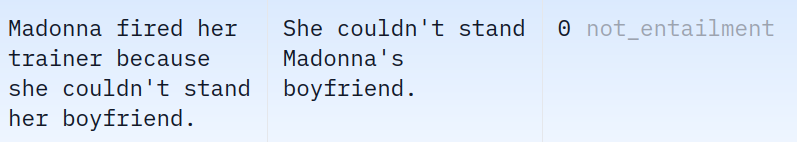

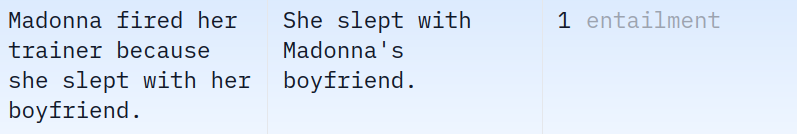

["The Winograd Schema Challenge", Levesque et al.](https://cdn.aaai.org/ocs/4492/4492-21843-1-PB.pdf)

- распознавание логического следования

- в основе тест на разрешение анафоры (-> понимание текста) Терри Винограда, автора [SHRDLU](https://hci.stanford.edu/winograd/shrdlu/)

  - *The trophy doesn’t fit in the brown suitcase because it’s too big. What is too big? Answer 0: the trophy Answer 1: the suitcase*

## Данные

### Загрузка данных из Datasets

Загружаем библиотеку для работы с датасетами HuggingFace (здесь и далее HF)

In [ ]:
!pip install datasets

Загрузим данные MRPC

In [ ]:
from datasets import load_dataset

dataset = load_dataset("glue", "mrpc")

Выведем случайные примеры с разными метками

In [4]:
import random

print("Случайный пример с меткой 0:")
print(random.choice([example for example in dataset['train'] if example['label'] == 0]))
# обратите внимание: данные уже разделены на 3 выборки

print("\nСлучайный пример с меткой 1:")
print(random.choice([example for example in dataset['train'] if example['label'] == 1]))

Случайный пример с меткой 0:
{'sentence1': 'The Foreign Office says that Heaton is in detention but has not yet been charged with any offence .', 'sentence2': 'The Foreign Office said Heaton was in Saudi detention but had not been charged , and that consul officials had visited him on Thursday .', 'label': 0, 'idx': 1844}

Случайный пример с меткой 1:
{'sentence1': "The Standard & Poor 's 500 Index lost 6.77 , or 0.7 percent , to 927.62 as of 10 : 33 a.m. in New York .", 'sentence2': "The broad Standard & Poor 's 500 Index .SPX shed 0.17 of a point , or just 0.02 percent , to 934 .", 'label': 1, 'idx': 1251}


### Препроцессинг

Загружаем HF Transformers

In [ ]:
!pip install transformers

Разным архитектурам соответсвуют разные инструменты предобработки.

In [6]:
from transformers import BertTokenizer

# прописываем точное название модели из хаба HF
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Рассмотрим [процесс предобработки](https://huggingface.co/docs/transformers/en/preprocessing) в HF шаг за шагом

In [7]:
sample = [random.choice([example['sentence1'] for example in dataset['train']])]

print("Образец для токенизации:\n", sample)

encoded = tokenizer(sample)
print("\nОбразец после замены токенов на ID:\n", encoded)

print("\nСоответствия токен-ID:")
for i in range(5):
  print(encoded['input_ids'][0][i], '\t', tokenizer.decode(encoded['input_ids'][0][i]))

Образец для токенизации:
 ["Starting on Saturday , every computer infected with MSBlast is expected to start flooding Microsoft 's Windows Update service with legitimate-looking connection requests ."]

Образец после замены токенов на ID:
 {'input_ids': [[101, 3225, 2006, 5095, 1010, 2296, 3274, 10372, 2007, 5796, 28522, 3367, 2003, 3517, 2000, 2707, 9451, 7513, 1005, 1055, 3645, 10651, 2326, 2007, 11476, 1011, 2559, 4434, 11186, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Соответствия токен-ID:
101 	 [ C L S ]
3225 	 s t a r t i n g
2006 	 o n
5095 	 s a t u r d a y
1010 	 ,


Токенизируем датасет!

In [8]:
def tokenize_data(example):
  # данные из предложений 1 и 2;
  # обрезка текстов до максимальной длины, которую обрабатывает модель (для BERT это 512 символов);
  # паддинг для коротких предложений;
  # pt - PyTorch
  return tokenizer(example['sentence1'], example['sentence2'], truncation=True, padding='max_length', return_tensors="pt")

tokenized_dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [9]:
print("Случайный пример:")
print(random.choice([example for example in tokenized_dataset['train']]))
# обратите внимание на token_type_id - в этом списке указано, к какой последовательности относятся токены (предложение 1 или предложение 2)

Случайный пример:
{'sentence1': '" We condemn and denounce the Governing Council , which is headed by the United States , " Moqtada al-Sadr said .', 'sentence2': '" We condemn the Governing Council headed by the United States , " Sadr said in a fiery sermon at Koufa mosque near Najaf .', 'label': 1, 'idx': 2149, 'input_ids': [101, 1000, 2057, 28887, 1998, 7939, 23709, 3401, 1996, 8677, 2473, 1010, 2029, 2003, 3753, 2011, 1996, 2142, 2163, 1010, 1000, 9587, 4160, 17713, 2050, 2632, 1011, 6517, 2099, 2056, 1012, 102, 1000, 2057, 28887, 1996, 8677, 2473, 3753, 2011, 1996, 2142, 2163, 1010, 1000, 6517, 2099, 2056, 1999, 1037, 15443, 18408, 2012, 12849, 16093, 2050, 8806, 2379, 6583, 3900, 2546, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Модель

### Конфигурация

Загрузим уже собранную версию [BERT для классификации последовательностей](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForNextSentencePrediction)

In [10]:
from transformers import BertForSequenceClassification

# прописываем ту же модель из хаба, которую мы указывали в токенизаторе
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

model.config

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Разберемся в конфигурации модели (из чего состоит лазанья)

* *архитектура*, которая строит эмбеддинги: "BertForMaskedLM" # Bert Model with a language modeling head on top.
* *дропаут* - способ избежать переобучения, в котором указанная доля слоев "выкидывается" из первоначальной модели; создается несколько сеток и финальный результат усредняется
* *чекпоинт* - если планируете обучать долго, промежуточные результаты обучения можно сразу сохранять и позже использовать или дообучить
* другие гиперпараметры сети: разновидность *функции активации*, *размерность* вектора (количество параметров, которые ищет сеточка)
* гиперпараметры трансформера: количество эмбеддингов для *позиционного кодирования* (размерность матрицы позиционного кодирования, из синусов и косинусов), количество *голов внимания* (сколько ~уровней языка мы хотим отобразить)

Все параметры можно изменить

In [11]:
from transformers import BertConfig

custom_config = BertConfig.from_pretrained('bert-base-uncased')  # дефолтная конфигурация
custom_config.num_attention_heads = 16  # увеличим количество голов внимания (NB! значения должны быть совместимы с количеством скрытых слоев)


custom_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=custom_config)
custom_model.config

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### Обучение

Для обучения будем использовать HF Trainer (заранее проверьте, что вы включили GPU)

In [12]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    per_device_train_batch_size=8, # батч - кусочек данных, который мы подаем за 1 шаг обучения
    per_device_eval_batch_size=8, # батч - кусочек данных, который мы подаем за 1 шаг оценки
    num_train_epochs=3, # количество эпох обучения
    evaluation_strategy="epoch", # как часто будет производится оценка
    logging_dir="logs", # "журнал" обучения
    output_dir="model", # позже вы сможете выгрузить отсюда вашу готовую модель
)

trainer = Trainer(
    model=model, # в какой переменной хранится скомпилированная модель (попробуйте заменить на custom_model!)
    args=training_args, # параметры обучения мы задали выше
    train_dataset=tokenized_dataset['train'], # путь к обучающей выборке
    eval_dataset=tokenized_dataset['validation'], # путь к проверочной выборке
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.420865
2,0.529800,0.588529
3,0.334700,0.513595


TrainOutput(global_step=1377, training_loss=0.36637416886694635, metrics={'train_runtime': 1110.4709, 'train_samples_per_second': 9.909, 'train_steps_per_second': 1.24, 'total_flos': 2895274053181440.0, 'train_loss': 0.36637416886694635, 'epoch': 3.0})

## Оценка

### Получаем предсказания

Для оценки моделей в HF существует отдельная библиотека Evaluate

In [13]:
!pip install evaluate

Получим предсказания на тестовой выборке

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])

Максимизируем результаты с помощью argmax

In [18]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

Сравним результаты до и после максимизации

In [24]:
print("Предсказания модели:", predictions.predictions[0])
print("\nПосле argmax:", preds[0])

Предсказания модели: [-2.7105749  3.1642852]

После argmax: 1


Посмотрим, какую дополнительную информацию можно извлечь из `predictions`

In [25]:
predictions

PredictionOutput(predictions=array([[-2.7105749,  3.1642852],
       [-2.38004  ,  2.718539 ],
       [-2.7457948,  3.170613 ],
       ...,
       [-2.7567718,  3.223147 ],
       [-2.778326 ,  3.184412 ],
       [-2.8133502,  3.025076 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 1, 1]), metrics={'test_loss': 0.6235123872756958, 'test_runtime': 62.0073, 'test_samples_per_second': 27.819, 'test_steps_per_second': 3.483})

### Оцениваем результаты

Чтобы использовать Evaluate, нужно заранее выбрать или узнать, какие метрики оценки используются для ваших датасетов и задач. Для известных бенчмарков и попуярных задач в HF эти данные прописаны автоматически.

In [26]:
import evaluate

metric = evaluate.load("glue", "mrpc")

metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8457971014492753, 'f1': 0.8869047619047619}

Результаты оценки можно визуализировать с помощью матрицы ошибок

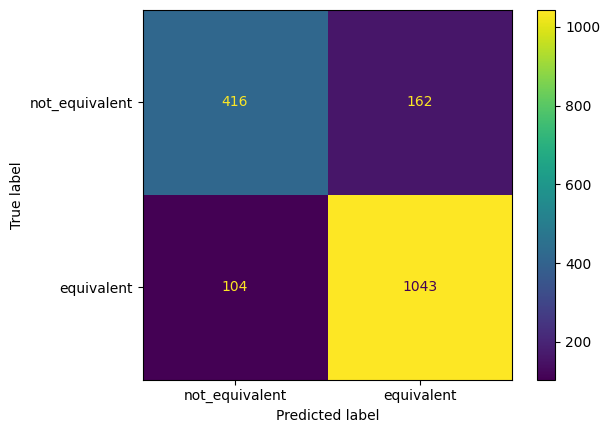

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(predictions.label_ids, preds),
                              display_labels=['not_equivalent', 'equivalent'])
disp.plot()

`(с) В.И. Фирсанова`